<a href="https://colab.research.google.com/github/tarisnyastamas/costofliving-dashboard/blob/main/L1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CIFAR10
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import pickle


## Numpy and pytorch

In [ ]:
a = np.random.rand(2,3)
print("Numpy array:")
print(a)
print("Shape: {}".format(a.shape))

Numpy array:
[[0.8906604  0.18724757 0.71000035]
 [0.92494346 0.76593681 0.48193991]]
Shape: (2, 3)


In [ ]:
t = torch.tensor(a)
print("Torch tensor:")
print(t)
print("Shape: {}".format(t.shape))

Torch tensor:
tensor([[0.8907, 0.1872, 0.7100],
        [0.9249, 0.7659, 0.4819]], dtype=torch.float64)
Shape: torch.Size([2, 3])


In [ ]:
print("Torch tensor on GPU: ")
print(t.cuda())

Torch tensor on GPU: 
tensor([[0.8907, 0.1872, 0.7100],
        [0.9249, 0.7659, 0.4819]], device='cuda:0', dtype=torch.float64)


Subpackages:
- nn
- optim
- nn.functional
- utils.data
- torchvision

## CIFAR10 dataset

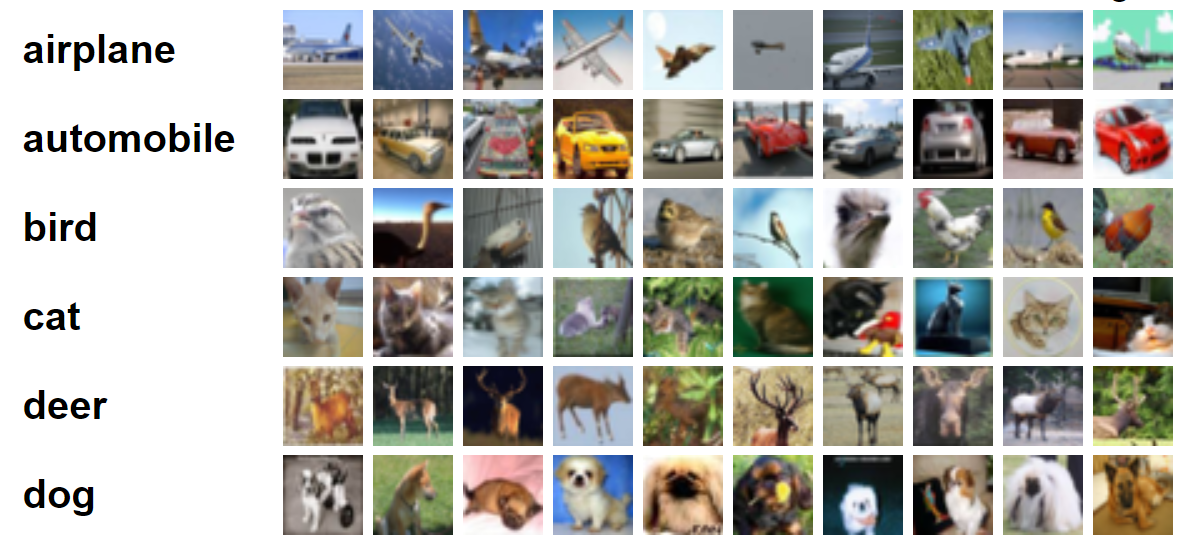

In [ ]:
# download cifar10 dataset
torchvision.datasets.CIFAR10(root='./data', train=True,
                            download=True)
torchvision.datasets.CIFAR10(root='./data', train=False,
                            download=True)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

In [ ]:
class CifarDataset(Dataset):
  def __init__(self, train=True, transforms=None):
    self.transforms = transforms
    self.data = []
    self.labels = []
      
    # load train data
    if train:
      for fname in ["data_batch_1", "data_batch_2", "data_batch_3", "data_batch_4", "data_batch_5"]:
        with open("/content/data/cifar-10-batches-py/" + fname, 'rb') as f:
            dict = pickle.load(f, encoding='bytes')
        self.data.append(dict[b'data'])
        self.labels += dict[b'labels']
      # create np.array from self.data with shape: (-1, img_width, img_height, nr_channels)
      # self.data = <your code here>
    else:
      # load test data
      with open("/content/data/cifar-10-batches-py/test_batch", 'rb') as f:
            dict = pickle.load(f, encoding='bytes')
      self.labels = dict[b'labels']
      # create np.array from self.data with shape: (-1, img_width, img_height, nr_channels)
      # use dict[b'data']
      # self.data = <your code here>

  def __len__(self):
    return self.data.shape[0]

  def __getitem__(self, idx):
    img = self.data[idx, ...]
    label = self.labels[idx]
    
    if self.transforms is not None:
      img = self.transforms(img)
    
    return img, torch.tensor(label)

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
trainset = CifarDataset(train=True, transforms=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = CifarDataset(train=False, transforms=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

In [ ]:
# 1. calculate some statistics

# print the min, max, mean and std of the image channels
data = trainset.data      # note: this is a numpy array
# <your code here>

Min:  [0 0 0]
Max:  [255 255 255]
Mean:  [125.30691805 122.95039414 113.86538318]
Std:  [62.99321928 62.08870764 66.70489964]


In [ ]:
# 2. plot a few images using trainset.data

In [ ]:
# 3. plot a few images using trainset[idx]

In [ ]:
# 4. try to reproduce the plot from step 2 (use trainset[idx])

In [ ]:
# during training you will use the trainloader and testloader objects
# a random batch from the loader:
data, labels = next(iter(trainloader))
print("Data shape: ", data.shape)
print("Labels shape", labels.shape)

Data shape:  torch.Size([64, 3, 32, 32])
Labels shape torch.Size([64])


## Convolutional neural network

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    self.conv1_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)

    self.conv2_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.conv2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

    self.conv3_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    self.conv3_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

    self.fc1 = nn.Linear(in_features=4*4*128, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=10)


  def forward(self, x):
    x = F.relu(self.conv1_1(x), inplace=True)
    x = F.relu(self.conv1_2(x), inplace=True)
    x = F.max_pool2d(x, kernel_size=2, stride=2)

    x = F.relu(self.conv2_1(x), inplace=True)
    x = F.relu(self.conv2_2(x), inplace=True)
    x = F.max_pool2d(x, kernel_size=2, stride=2)

    x = F.relu(self.conv3_1(x), inplace=True)
    x = F.relu(self.conv3_2(x), inplace=True)
    x = F.max_pool2d(x, kernel_size=2, stride=2)

    x = x.view(-1, 4*4*128)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)    
    
    x = F.log_softmax(x, dim=1)
    return x

In [ ]:
def train(net, data_loaders, epochs, lr):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  
  net.to(device)
  optimizer = torch.optim.Adam(net.parameters(), lr=lr)
  loss_fn = nn.NLLLoss()

  losses = {"train": []}

  for epoch in range(epochs):
    phase = 'train'
    acc_sum = 0
    with torch.set_grad_enabled(phase == 'train'):
      for i, (input, target) in enumerate(data_loaders[phase]):
        input = input.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = net(input)
        loss = loss_fn(output, target)

        losses[phase].append(loss.item())
        acc_sum += (target == output.argmax(dim=1)).sum().item()

        loss.backward()
        optimizer.step()

        if i % 200 == 0:
          print("Phase={}; Epoch={:2d}; Iter={:5d}; Loss batch={}".format(
              phase, epoch, i, loss.item())
          )
        
      acc = acc_sum * 1.0 / len(data_loaders[phase].dataset)
      print("Phase={}; Epoch={:2d}; Acc: {}".format(
              phase, epoch, acc ))
      print('----------------------------------------------------------------------------')

  return losses

In [ ]:
net = CNN()
epochs = 10
lr = 1e-3

data_loaders = {'train': trainloader, 'test': testloader}

In [ ]:
losses = train(net, data_loaders, epochs, lr)

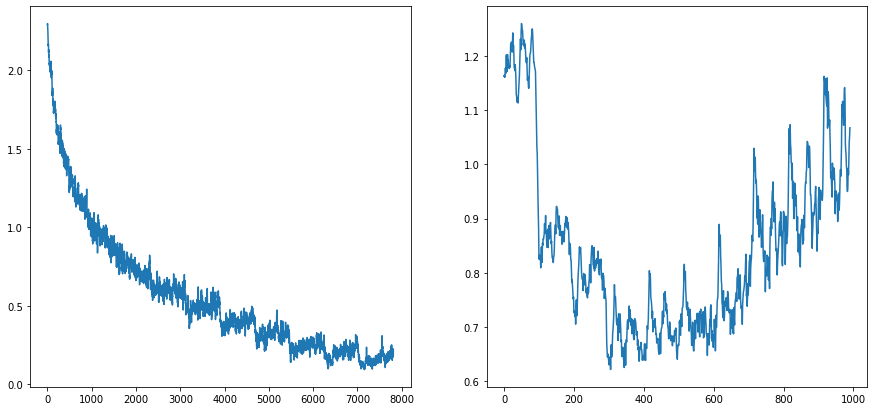

In [ ]:
smooth_train_loss = np.convolve(losses['train'], np.ones((10,))/10, mode='valid')
smooth_test_loss = np.convolve(losses['test'], np.ones((10,))/10, mode='valid')
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].plot(smooth_train_loss)
ax[1].plot(smooth_test_loss)
plt.show()